## Описание проекта
Компания «Работа с заботой» предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

<font size=+1><b>Цель проекта:</b></font> проанализировать данные о сотрудниках, предоставленные компанией, и на основе выявленных закономерностей и моделей машинного обучения сформулировать основные рекомендации для бизнеса, которые помогут снизить неожиданный  отток сотрудников.

На основе этой цели сформулировано две основных задачи. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

<font size=+1><b>План исследования:</b></font>
- Для решения первой задачи:
    1. На первом этапе произведем [загрузку данных](#1), предоставленных для решения первой задачи.
    2. На втором этапе необходимо провести [предобработку данных](#2): обработать дубликаты, пропуски, изменить тип данных там, где это необходим, устранить неявные дубликаты.
    3. На этапе [исследовательского анализа](#3) построим гистограммы распределения, столбчатые диаграммы, диаграммы размаха и обработаем аномальные значения, выявим основные закономерности в данных.
    4. На этапе [корреляционного анализа](#4) рассчитаем корреляцию между всеми признаками, изучим данные на наличие мультиколлинеарности.
    5. Затем создадим [пайплайн](#5), с помощью которого подготовим данные (заполним пропуски, закодируем нужные признаки и тд) и обучим две модели: `DecisionTreeRegressor()`и `LinearRegression()` - для каждой подберем гиперпараметры. [Выбрав лучшую модель](#6) и ее гиперпараметры, получим предсказания уровня удовлетворенности сотрудника работой на тестовой выборке.
    6. Сделаем промежуточные [выводы](#7).
- Для решения второй задачи:
    1. Аналогично повторим предыдущие этапы: произведем [загрузку данных](#8), предоставленных для решения второй задачи, затем проведем [предобработку данных](#9) и [исследовательский анализ](#10).
    2. При необходимости добавим [дополнительные признаки](#11)
    5. Вновь создадим [пайплайн](#12) и обучим три модели: `DecisionTreeClassifier()`, `LogisticRegression()`, `KNeighborsClassifier()`. С помощью метрики ROC_AUC [выберем лучшую модель](#13) и с ее помощью получим предсказание меток классов.
    6. Сделаем промежуточные [выводы](#14).
- Сделаем [общие выводы](#15).

In [1]:
# установим библиотеку для корреляционного анализа
!pip install phik==0.10.0 -q
import phik

# установим версию библиотеки scikit-learn 1.1.3
!pip install scikit-learn==1.1.3 -q

# установим бибиотеку для метода SHAP
! pip install shap -q
import shap

Импортируем нужные библиотеки:

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# загрузим классы для преобразования данных
from sklearn.preprocessing import (OneHotEncoder, StandardScaler, 
                                   MinMaxScaler, OrdinalEncoder, LabelEncoder)

# загрузим классы для заполнения пропусков
from sklearn.impute import SimpleImputer

# загрузим нужные модели
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# импортируем класс для создания собственной метрики
from sklearn.metrics import make_scorer

# загрузим нужную метрику
from sklearn.metrics import roc_auc_score

# загрузим инструменты для автоматизированного подбора гиперпараметров
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# импортируем функцию для кросс-валидации
from sklearn.model_selection import cross_val_score

# импортируем инструменты для проведения статтеста
from scipy import stats as st

# константы
RANDOM_STATE = 42

## Задча 1:  предсказание уровня удовлетворённости сотрудника
Первая задача — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.

<a id='1'></a>
### Загрузка данных
Загрузим данные из датафреймов для решения первой задачи:

In [3]:
df_train = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv', sep=',')
features_test = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
target_test = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

Изучим общую информацию о данных.

In [4]:
def main_info(data):
    print(data.info())
    display(data.head(10))
    print('\n')
    print('Общее число строк и столбцов в датафрейме:')
    print(data.shape)

Первый датафрейм - это тренировчоная выборка, которая содержит данные о сотрудниках компании.

In [5]:
main_info(df_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78
6,857135,sales,sinior,medium,9,no,no,3,56400,0.56
7,400657,purchasing,middle,high,9,no,no,3,52800,0.44
8,198846,hr,junior,low,1,no,no,2,13200,0.14
9,149797,technology,middle,high,6,no,no,3,54000,0.47




Общее число строк и столбцов в датафрейме:
(4000, 10)


Второй датафрейм - это тестовая выборка.

In [6]:
main_info(features_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400




Общее число строк и столбцов в датафрейме:
(2000, 9)


In [7]:
main_info(target_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
5,817219,0.76
6,269033,0.64
7,962356,0.38
8,649052,0.14
9,532834,0.59




Общее число строк и столбцов в датафрейме:
(2000, 2)


**Выводы:** данные корректные и соответсвуют описанию; в тренировочных и тестовых выборках есть несколько пропусков в столбцах `dept`и `level`. Соотношение данных в тренировочной и тестовой выборке 2:1. В тренировчоной выборке 4000 строк, в тестовой выборке 2000.

<a id='2'></a>
### Предобработка данных
**Проведем предобработку данных для тестовой выборки.**

Переведем столбец `id`  в индексы для удобства дальнейшей работы, так как он не нужен для обучения модели.

In [8]:
df_train.set_index('id', inplace=True)

Вначале проверим данные на наличие полных дубликатов:

In [9]:
print ('Количество полных дубликатов: ', df_train.duplicated().sum())

Количество полных дубликатов:  245


Всего в данных 245 полных дубликатов, это значит, что в компании есть разные сотрудники, у которых полностью совпадают все параметры, за исключением *id*. Теоретически сотрудники с одинаквыми наборами признаков могут существовать в компании. Однако для обучения модели повторяющиеся строки не нужны, поэтому можем их удалить.

In [10]:
df_train.drop_duplicates(inplace=True)
print ('Размер обучающей выборки после удаления дубликатов:', df_train.shape)

Размер обучающей выборки после удаления дубликатов: (3755, 9)


Проверим нет ли в данных ошибок. Выведем уникальные значения столбцов датафрейма.

In [11]:
# уникальные значения в столбце dept
df_train['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

In [12]:
# уникальные значения в столбце level
df_train['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [13]:
# уникальные значения в столбце workload
df_train['workload'].unique()

array(['medium', 'high', 'low'], dtype=object)

Ошибок в данных нет, все категориальные значения внесены корректно. Тип данных во всех столбцах верный.

На предыдущем этапе в данных были обнаружены пропуски в столбцах `dept`(отдел, в котором работает сотрудник) и `level`(уровень занимаемой должности).

In [14]:
df_train.isna().sum()

dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Количество пропусков небольшое. Заполним их на этапе подготовки данных к обучению модели в пайплайне.

**Проведем предобработку данных для тестовой выборки.**

In [15]:
print ('Количество полных дубликатов в тестовой выборке:', features_test.drop('id', axis=1).duplicated().sum())

Количество полных дубликатов в тестовой выборке: 557


Не будем удалять полные дубликаты из тестовой выборки.

Проверим датафрейм на наличие ошибок в данных, для этого выведем уникальные значения в столбцах с категориальными переменными.

In [16]:
# уникальные значения в столбце dept
features_test['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

В столбце `dept` есть пропуски, а также пустые строки. Обработаем их в пайплайне на этапе подготовки данных.

In [17]:
# уникальные значения в столбце level
features_test['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [18]:
# уникальные значения в столбце workload
df_train['workload'].unique()

array(['medium', 'high', 'low'], dtype=object)

**Выводы:** 

Тип данных для всех признаков - корректный. 

В тренировочной выборке было обнаружено 245 полных дубликатов, те такие сотрудники, у которых полностью совпадают все признаки кроме `id`. Было принято решение удалить дубликаты  из тренировочной выборки, так как они могут мешать обучению модели и искажать результаты. В данных есть небольшое количество пропусков в столбцах `dept` и `level`, заполним их на следующем шаге в пайпалйне.

В тестовом датафрейме  было обнаружено 557 дубликатов, которые были оставлены в выборке. Также в столбце `dept` тестовой выборки помимо пропусков, были обнаружены пустые строки, которые также необходимо будет обработать в пайпалайне.

<a id='3'></a>
### Исследовательский анализ данных
Отберем категориальные и количественные признаки.

In [19]:
cat_col_names = df_train.select_dtypes(exclude='number').columns.tolist()
cat_col_names

['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

In [20]:
num_col_names = df_train.select_dtypes(include='number').columns.tolist()
# исключим целевой признак
num_col_names.remove('job_satisfaction_rate')
num_col_names

['employment_years', 'supervisor_evaluation', 'salary']

#### Количественные признаки
Напишем функцию, которая будет возвращать статистические данные по каждому столбцу с количественными значениями, а также строить диаграммы размаха и гистограммы распределения.

In [21]:
def hist_boxplot(data, name_column, num=10):
    print (f'Статистические данные по столбцу "{name_column}"')
    display(data.describe())
    fid, ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].set(title=f'Гистограмма распределения для столбца "{name_column}"')
    data.hist(bins=num, grid=True, ax=ax[0])
    ax[0].set(xlabel=name_column)
    ax[0].set(ylabel=f'Распределение {name_column}')
    ax[1].set(title=f'Диаграмма размаха для столбца "{name_column}"')
    data.plot(kind='box', ax=ax[1])
    plt.show()

Исследуем данные в столбце `employment_years`, который содержит данные о длительности работы сотрудников в комапнии (в годах).

Статистические данные по столбцу "employment_years"


count    3755.000000
mean        3.817044
std         2.557142
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

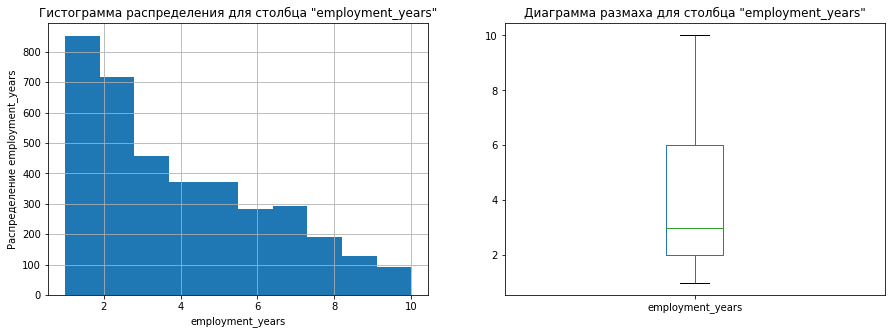

In [22]:
hist_boxplot(df_train['employment_years'], 'employment_years', num=10)

Больше половины всех сотрудников имеют опыт работы в компании до 3-х лет (включительно). Более 800 сотрудников работают в компании 1 год. Средний срок сработы в компании - около трех лет. 75% сотрудников имеют опыт работы до 6 лет (включительно). Наибольший срок работы в компании - 10 лет. Выбросов в данных нет.

Построим гистограмму и диаграмму размаха для столбца  `supervisor_evaluation`, который содержит оценку качества работы сотрудника, которую дал руководитель.

Статистические данные по столбцу "supervisor_evaluation"


count    3755.000000
mean        3.463648
std         1.026265
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

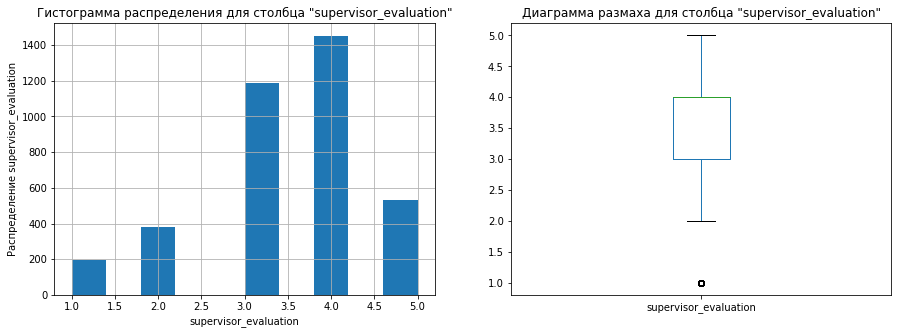

In [23]:
hist_boxplot(df_train['supervisor_evaluation'], 'supervisor_evaluation', num=10)

In [24]:
df_train[df_train['supervisor_evaluation']==1].count()

dept                     198
level                    198
workload                 198
employment_years         198
last_year_promo          198
last_year_violations     198
supervisor_evaluation    198
salary                   198
job_satisfaction_rate    198
dtype: int64

Большинство руководителей оценивают своих сотрудников на 4 балла. Около 1200 сотрудников получили оценку в 3 балла. Порядка 200 сотрудников получили оценку в 1 балл.

Построим графики для столбца `salary`, который содержит данные о зарплате сотрудников.

Статистические данные по столбцу "salary"


count     3755.000000
mean     34457.416778
std      15050.643870
min      12000.000000
25%      22800.000000
50%      31200.000000
75%      44400.000000
max      98400.000000
Name: salary, dtype: float64

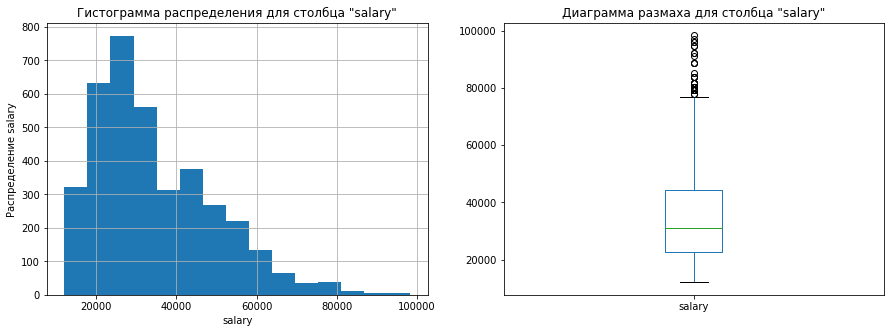

In [25]:
hist_boxplot(df_train['salary'], 'salary', num=15)

In [26]:
print ('Медианная зарплата:')
df_train['salary'].median()

Медианная зарплата:


31200.0

In [27]:
print ('Уровень загруженность сотрудников с высокой зп:', df_train.query('salary > 80000')['workload'].unique())
print ('Должность сотрудников с высокой зп:', df_train.query('salary > 80000')['level'].unique())

Уровень загруженность сотрудников с высокой зп: ['high']
Должность сотрудников с высокой зп: ['sinior']


**Вывод**: Медианная зарплата составляет 31 200 рублей. 75% сотрудников компании получают зарплату до 45 000 рублей. В заработных платах сотрудников есть большое количество выбросов - зарплаты свыше 80 000 рублей. Все сотрудники, получающие заработную плату свыше 80 000 рублей, являются сеньорами и имеют высокий уровень загруженность. Такие данные явяляются правдоподобными, потоэтому оставим их.

Проведем исследование в разрезе целевого признака. Разделим данные на две категории: те сотрудники, у которых удовлетворенность работой `job_satisfaction_rate` меньше 0.5 (удовлетворенность низкая), и те - у которых `job_satisfaction_rate` больше 0.5 (удовлетворенность высокая).

In [28]:
df_train_low_rate = df_train[df_train['job_satisfaction_rate'] <= 0.5]
df_train_high_rate = df_train[df_train['job_satisfaction_rate'] > 0.5]

In [29]:
print ('Размерность первой выборки:')
df_train_high_rate.shape

Размерность первой выборки:


(2102, 9)

In [30]:
print ('Размерность второй выборки:')
df_train_low_rate.shape

Размерность второй выборки:


(1653, 9)

Построим гистограммы распределения для этих дву категорий, чтобы сравнить их.

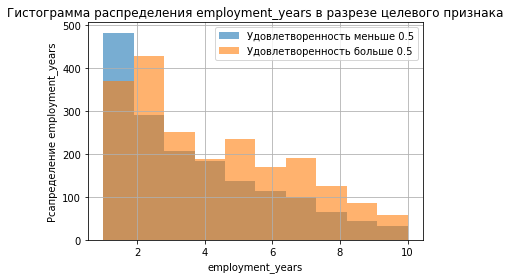

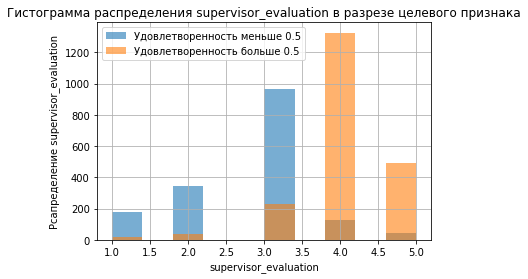

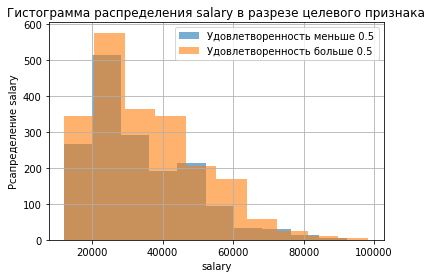

In [31]:
for name_column in num_col_names:
    df_train_low_rate[name_column].plot(kind='hist', bins=10, alpha=0.6, grid=True, 
                                        label='Удовлетворенность меньше 0.5')
    df_train_high_rate[name_column].plot(kind='hist', bins=10, alpha=0.6, grid=True,
                                        label='Удовлетворенность больше 0.5')
    plt.xlabel(name_column)
    plt.ylabel(f'Рсапределение {name_column}')
    plt.title(f'Гистограмма распределения {name_column} в разрезе целевого признака')
    plt.legend()
    plt.show();

**Вывод:** 

Среди сотрудников, чья удовлетворенность выше 0.5:
- наибольшее число сотрудников работает в компании 2 года, тогда как среди сотрудников, чья удовлетворенность меньше 0.5 - большинство работает в компании 1 год.
- доля сотрудников, работающих более 5 лет выше, чем среди сотрудников с низкой удовлетворенностью.
- подавляющее большинство оценок - 4, среди сотрудников во второй категории - 3.
- доля людей с заработной платой выше медианной (45 000 рублей) выше, чем среди сотрудников во второй группе.

#### Категориальные признаки
Построим столбчатые диаграммы для категориальных признаков.

In [32]:
def diag_bar(data, name_column):
        print (f'Столбчатая диаграмма для столбца "{name_column}"')
        print(data
              .value_counts()
              .plot(kind='barh', grid=True, figsize=(10,5))
             )
        plt.xlabel(name_column)
        plt.ylabel('Количество_сотрудников')
        plt.show();

Столбчатая диаграмма для столбца "dept"
AxesSubplot(0.125,0.125;0.775x0.755)


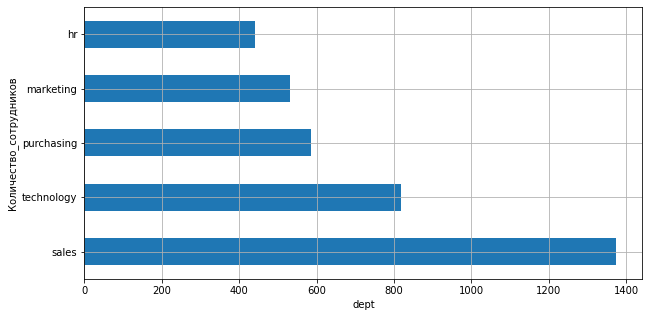

Столбчатая диаграмма для столбца "level"
AxesSubplot(0.125,0.125;0.775x0.755)


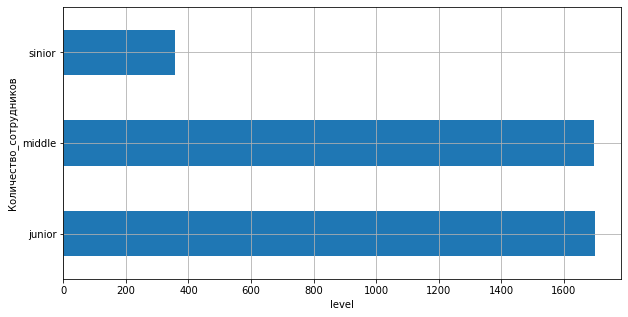

Столбчатая диаграмма для столбца "workload"
AxesSubplot(0.125,0.125;0.775x0.755)


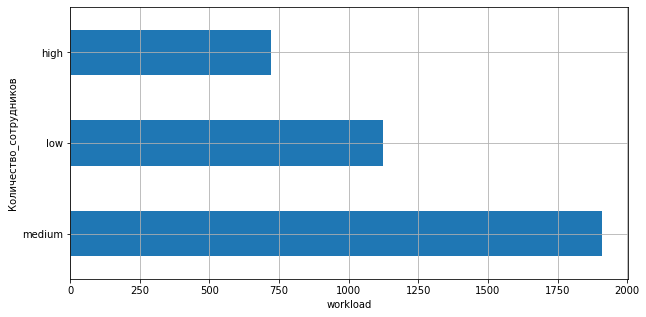

Столбчатая диаграмма для столбца "last_year_promo"
AxesSubplot(0.125,0.125;0.775x0.755)


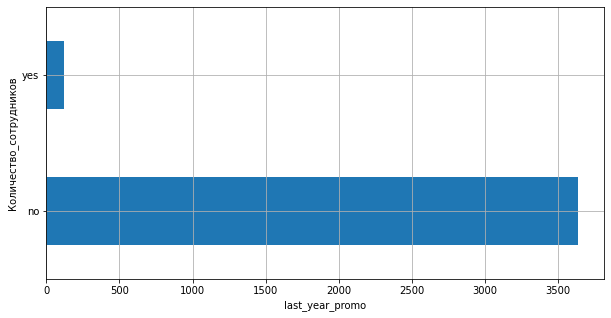

Столбчатая диаграмма для столбца "last_year_violations"
AxesSubplot(0.125,0.125;0.775x0.755)


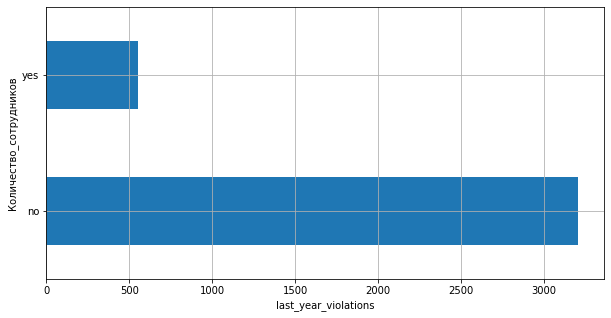

In [33]:
for name_col in cat_col_names:
    diag_bar(df_train[name_col], name_col)

**Вывод:** 
- большинство сотрудников работает в отделе продаж `sales`, второе место занимает отдел `technology`, наименее популярный отдел - `hr`.
- сотрудников уровня `middle` и `junior` примерно поровну - свяще 1600, сотрудников уровня `sinior` гораздо меньше - менее 400.
- большинство сотрудников (свыше 1750) имеют средний `medium` уровень загруженности `workload`.
- у подавляющего большинства сотрудников (свяше 3500 тысяч) повышений за прошлый год не было.
- свыше 500 сотрудников нарушили трудовой договор за прошлый год.

Изучим эти же признаки в разрезе целевого признака, чтобы посмотреть как менялись показатели в зависимости от уровня удовлетворенности сотрудника.

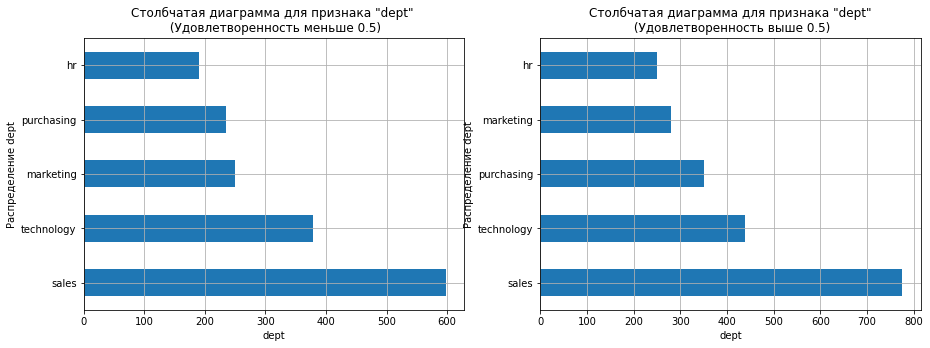

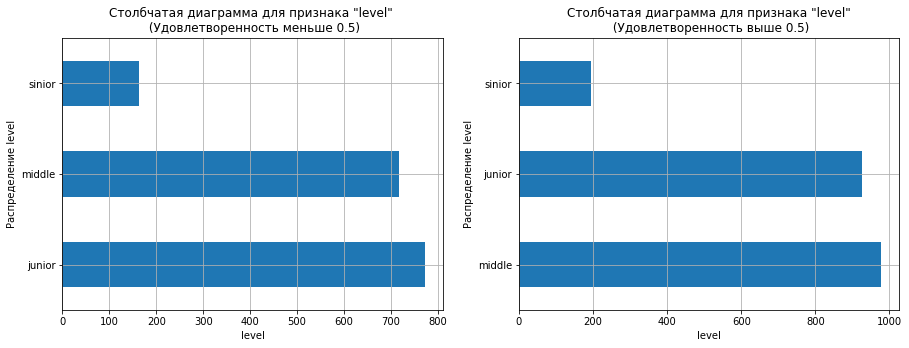

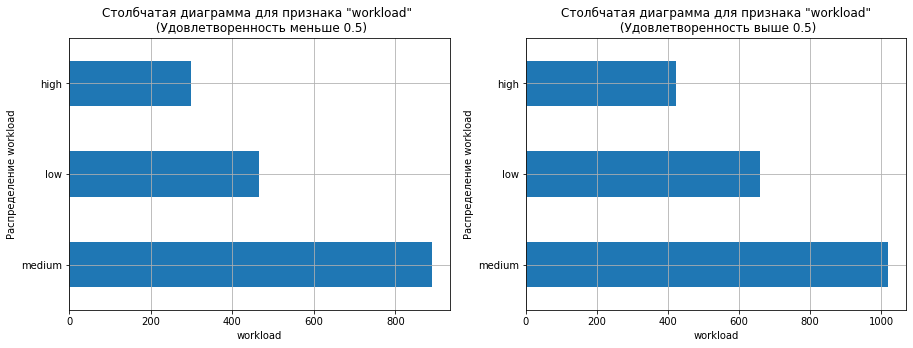

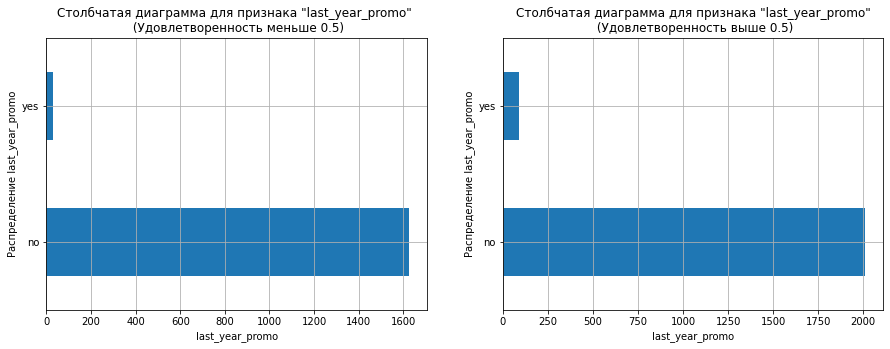

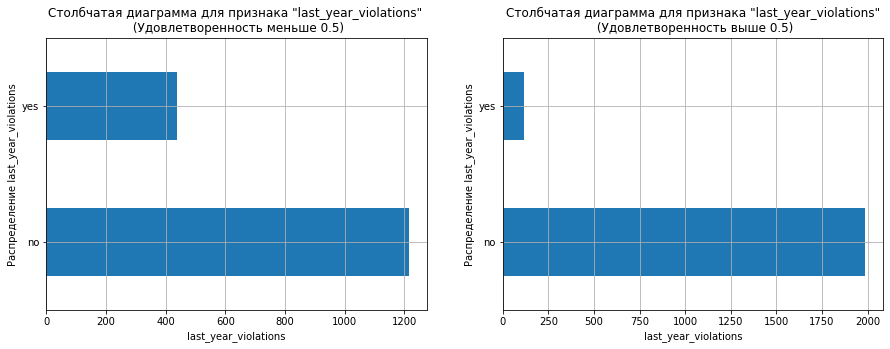

In [34]:
for name_col in cat_col_names:
    fid, ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].set(title=f'Столбчатая диаграмма для признака "{name_col}" \n (Удовлетворенность меньше 0.5)')
    df_train_low_rate[name_col].value_counts().plot(kind='barh', grid=True, ax=ax[0])
    ax[0].set(xlabel=name_col)
    ax[0].set(ylabel=f'Распределение {name_col}')
    ax[1].set(title=f'Столбчатая диаграмма для признака "{name_col}"\n (Удовлетворенность выше 0.5)')
    df_train_high_rate[name_col].value_counts().plot(kind='barh', grid=True, ax=ax[1])
    ax[1].set(xlabel=name_col)
    ax[1].set(ylabel=f'Распределение {name_col}')
    plt.show()

**Вывод:**
- Доля сотрудников с удовлетворенностью работой ниже 0.5 составляют около 50% практически во всех отделах.
- Среди сотрудников c должностью `junior`: примерно 750 удовлетворены работой менее чем на 0.5, а около 900 - более чем на 0.5.
- Среди сотрудников с должностью `middle`: чуть больше 700 удовлетворены работой менее чем на 0.5, а более 900 - более чем на 0.5.
- Среди сотрудников с низким уровнем удовлетворенности работой около трети получали выговор по трудовому договору за прошлый год, тогда как среди тех, кто удовлетворен своей работой более чем на 0.5 доля выговоров гораздо меньше.

#### Общие выводы
- Средний срок сработы в компании - около трех лет.
- В заработных платах сотрудников есть некоторое количество выбросов - зарплаты свыше 80 000 рублей (при медианной зарпалате в 31 200 рублей). Все сотрудники, получающие заработную плату свыше 80 000 рублей, являются сеньорами и имеют высокий уровень загруженность.
- Большинство "новичков", работающих менее 1 года имеют удовлетворенность работой менее 0.5.
- Среди сотрудников, чья удовлетворенность выше 0.5, подавляющее большинство  имеет оценку от руководства - 4, среди сотрудников во второй категории - 3.
- Большинство сотрудников работает в отделе продаж `sales`, второе место занимает отдел `technology`, наименее популярный отдел - `hr`.
- Сотрудников уровня `middle` и `junior` примерно поровну - свыше 1600, сотрудников уровня `sinior` гораздо меньше - менее 400.
- Среди сотрудников с низким уровнем удовлетворенности работой около трети получали выговор по трудовому договору за прошлый год, тогда как среди тех, кто удовлетворен своей работой более чем на 0.5 доля выговоров гораздо меньше.

<a id='4'></a>
### Корреляционный анализ
Провеедм корреляционный анализ. С помощью метода `phik_matrix` вычислим корреляцию между всеми признаками, в том числе между категориальными и количественными. С помощью метода `heatmap` из библиотеки `seaborn` визуализируем расччитанную матрицу корреляции.

<AxesSubplot:>

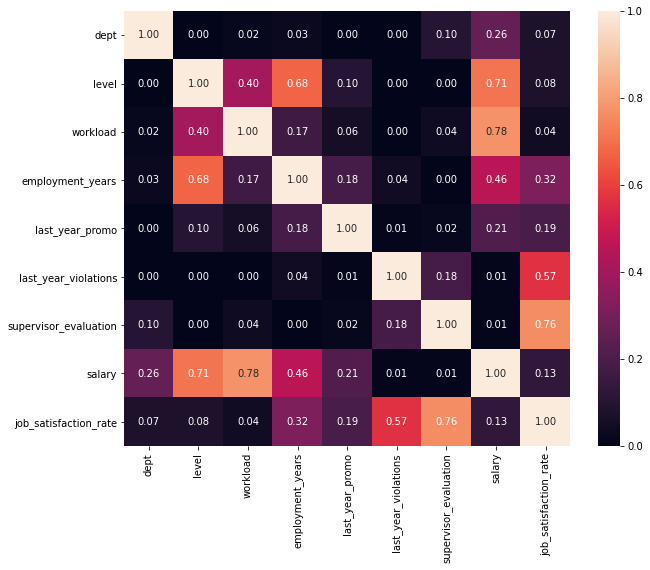

In [35]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
sns.heatmap(df_train.phik_matrix(interval_cols=['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']), 
            annot=True, fmt='.2f')

**Выводы:**
- можно отметить высокую корреляцию (0.71) между признаками `level` и `salary`, а также между признаками `level` и `employment_years`(0.68). Следовательно, чем выше уровень, занимаемой должности, тем больше заработная плата и срок работы человека в компании. 
- высокая корреляция также присутствует между признаками `supervisor_evaluation` и `job_satisfaction_rate`. Эта зависимость была отмечена и на предыдущем этапе анализа: чем выше оценка работника, полученная от начальства, тем более он удовлетворен работой.
- также высокая корреляция наблюдается между признаками `workload` (уровень загруженности) и `salary` (зарплата).
- мультиколлениарности между признаками не наблюдается.

<a id='5'></a>
### Подготовка данных

Разделим датафрейм на выходные признаки и целевой признак.

In [36]:
# входные признаки
X_train = df_train.drop('job_satisfaction_rate', axis=1)
X_train

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000
653870,hr,junior,high,2,no,no,5,38400
184592,sales,junior,low,1,no,no,2,12000
171431,technology,junior,low,4,no,no,2,18000
693419,hr,junior,medium,1,no,no,3,22800
...,...,...,...,...,...,...,...,...
424345,hr,sinior,high,6,no,no,4,80400
855240,sales,junior,medium,2,no,no,3,20400
533318,sales,middle,low,7,no,no,5,24000


In [37]:
# целевой признак
y_train = df_train['job_satisfaction_rate']
y_train

id
155278    0.58
653870    0.76
184592    0.11
171431    0.37
693419    0.20
          ... 
424345    0.88
855240    0.27
533318    0.76
706868    0.48
338347    0.18
Name: job_satisfaction_rate, Length: 3755, dtype: float64

Отберем признаки, к которым будем применять OHE-кодирование.

In [38]:
# отберем только категориальные признаки
ohe_columns= X_train.select_dtypes(exclude='number').columns.tolist()
# исключим те признаки, которые будем кодировать с помощью другого метода
ohe_columns.remove('level')
ohe_columns.remove('workload')
ohe_columns

['dept', 'last_year_promo', 'last_year_violations']

Отберем признаки, к которым будем применять Ordinal-кодирование.

In [39]:
ord_columns = ['level', 'workload']

Отберем признаки, к которым будем применять масштабирование.

In [40]:
num_columns = X_train.select_dtypes(include='number').columns.tolist()
num_columns

['employment_years', 'supervisor_evaluation', 'salary']

#### Подготовим тестовые данные
В датафрйемах `features_test` и `target_test` порядок строк не совпадает. Это может привести к ошибкам при тестировании моделей, поэтому для начала объединим два датафрейма по `id`, а затем снова разделим на входные признаки и таргет.

In [41]:
# объединяем датафреймы
test_full = features_test.merge(target_test, on='id')

In [42]:
print('Размерность датафрейма features_test:', features_test.shape)
print('Размерность датафрейма target_test:', target_test.shape)
print('Размерность объединенного датафрейма:', test_full.shape)
test_full.head()

Размерность датафрейма features_test: (2000, 9)
Размерность датафрейма target_test: (2000, 2)
Размерность объединенного датафрейма: (2000, 10)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


Отберем только входные признаки `X_test` и преобразуем колонку с `id` пользователей в индексы. 

In [43]:
X_test = test_full.drop('job_satisfaction_rate', axis=1)
X_test.set_index('id', inplace=True)
X_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


Выделим целевую переменную `y_test`:

In [44]:
y_test = test_full['job_satisfaction_rate']
# выведем первые строки
y_test

0       0.79
1       0.72
2       0.64
3       0.60
4       0.75
        ... 
1995    0.56
1996    0.14
1997    0.11
1998    0.43
1999    0.67
Name: job_satisfaction_rate, Length: 2000, dtype: float64

#### OHE-кодирование
Создадим пайплайн `ohe_pipe`. Он будет содержать следующие шаги:
- шаг `simple_imputer_ohe_1`: заполнение пропущенных значений наиболее часто встречающимся;
- шаг `simple_imputer_ohe_2`: заполнение пустых строк наиболее часто встречающимся значением;
- шаг `ohe`: кодирование данных с помощью `OneHotEncoder`, метод `handle_unknown='ignore'` проигнорирует неизвестные категории (тех, что не было в тренировочоной выборке).

In [45]:
ohe_pipe = Pipeline(
    [
        
        (
            'simple_imputer_ohe_1',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        
        (
            'simple_imputer_ohe_2',
            SimpleImputer(missing_values=' ', strategy='most_frequent')
        ),
        
        (
            'ohe',
             OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
)

#### Ordinal-кодирование
Применим ordinal-кодирование для признаков `level` и `workload`. Создадим пайплайн `ord_pipe`, который будет содержать следующие шаги:
- шаг `ord`: кодирование данных с помощью `OrdinalEncoder`, переменной `unknown_value` передадим значение `np.nan`, которым будет закодирована неизвестная категория (если она встретится), порядок категоризации зададим так:
    - "junior" < "middle"< "sinior";
    - "low" < "medium" < "high".
- шаг `simple_imputer_after`: заполнение пропусков, которые появятся после кодирования с помощью `SimpleImputer`.

In [46]:
ord_pipe = Pipeline(
    [
        
        (
        'simple_imputer_befor_ord',
        SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan)
        ),
        
        (
            'simple_imputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
        
    ]
)

#### Объединяем шаги
Создадим пайплайн `data_preprocessing`, где с помощью `ColumnTransformer` объединим пайплайны для масштабирования и кодирования данных. 

Зададим параметер `remainder='passthrough'`, это позволит оставить без изменений те данные, которые не будут обработаны на предыдущих шагах.

In [47]:
data_preprocessing = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

#### Финальный пайплайн

In [48]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessing),
        ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

Создадим словарь гиперпараметров, где укажем гиперпараметры для двух моделей: дерева решений `DecisionTreeRegressor` и линейной регрессии `LinearRegression`.

In [49]:
parameters_grid = [
    {
        'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'model__max_depth': range(2,20),
        'model__max_features': range(5,10),
        'model__min_samples_split': range(3,6),
        'model__min_samples_leaf': range(3,6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'model': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]

<a id='6'></a>
### Обучение модели

Напишем функцию, которая будет вычислять нужную нам метрику `SMAPE`. В качестве агрументов, передадим функции:
- `y_true` - истинные значения целевого признака
- `y_pred` - значения, предсказанные моделью.

In [50]:
def SMAPE_metric(y_true, y_pred):     
    items = abs(y_true - y_pred)/((abs(y_true)+abs(y_pred))/2)
    summ = items.sum()
    n = len(items)
    SMAPE = 100 * summ / n
    return SMAPE

С помощью функции `make_scorer` создадим свою метрику, передав ей в качестве аргументов функцию `SMAPE_metric` и параметр `greater_is_better` равный False, те чем выше будет значение метрики, тем хуже качество модели.

In [51]:
scorer = make_scorer(SMAPE_metric, greater_is_better=False)

Найдем лучшую модель на тренировчоных данных с помощью `RandomizedSearchCV`.  В качестве метрики для оценки качества модели передадим свою метрику `scorer`. Критерием успеха будем считать SMAPE ≤ 15 на тестовой выборке.

In [52]:
random_search = RandomizedSearchCV(
    pipe_final,
    parameters_grid,
    scoring=scorer,
    n_jobs=-1,
    cv=5,
    n_iter=10,
    random_state=RANDOM_STATE
)

Обучим модель на тренировочных данных.

In [53]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simple_imputer_ohe_1',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('simple_imputer_ohe_2',
                                                                                                SimpleImputer(missing_values=' ',
                                                                                                              strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'...
                                         'model__max_depth': range(2, 20),
                                         'model__max_features': range(5, 10),
                                         'model__min_samples_leaf': range(3, 6),
                                         'model__min_samples_split': range(3, 6),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'model': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42,
                   scoring=make_scorer(SMAPE_metric, greater_is_better=False))

Сохраним лучшую модель в переменную `best_model`.

In [54]:
best_model = random_search.best_estimator_

In [ ]:
best_model

Выведем параметры лучшей модели:

In [55]:
random_search.best_params_

{'preprocessor__num': StandardScaler(),
 'model__min_samples_split': 3,
 'model__min_samples_leaf': 3,
 'model__max_features': 8,
 'model__max_depth': 13,
 'model': DecisionTreeRegressor(max_depth=13, max_features=8, min_samples_leaf=3,
                       min_samples_split=3, random_state=42)}

Выведем метрику, полученную на лучшей модели:

In [56]:
print ('Метрика лучшей модели на тренировочных данных: ', random_search.best_score_)

Метрика лучшей модели на тренировочных данных:  -15.294535256181982


Выведем лучшие результаты подбора моделей: 

In [57]:
result_models = pd.DataFrame(random_search.cv_results_)
# отсортируем их по убыванию метрики и выведем топ-10 лучших моделей.
(result_models[['rank_test_score', 'param_model', 'mean_test_score','params']]
.sort_values('rank_test_score')
.head(10))

,rank_test_score,param_model,mean_test_score,params
6,1,"DecisionTreeRegressor(max_depth=13, max_featur...",-15.294535,"{'preprocessor__num': StandardScaler(), 'model..."
1,2,"DecisionTreeRegressor(max_depth=13, max_featur...",-15.395644,"{'preprocessor__num': MinMaxScaler(), 'model__..."
0,3,"DecisionTreeRegressor(max_depth=13, max_featur...",-15.413168,"{'preprocessor__num': StandardScaler(), 'model..."
9,4,"DecisionTreeRegressor(max_depth=13, max_featur...",-15.451694,"{'preprocessor__num': StandardScaler(), 'model..."
3,5,"DecisionTreeRegressor(max_depth=13, max_featur...",-15.699173,"{'preprocessor__num': StandardScaler(), 'model..."
4,6,"DecisionTreeRegressor(max_depth=13, max_featur...",-16.094474,"{'preprocessor__num': StandardScaler(), 'model..."
2,7,"DecisionTreeRegressor(max_depth=13, max_featur...",-16.523106,"{'preprocessor__num': StandardScaler(), 'model..."
5,8,"DecisionTreeRegressor(max_depth=13, max_featur...",-16.572765,"{'preprocessor__num': MinMaxScaler(), 'model__..."
8,9,"DecisionTreeRegressor(max_depth=13, max_featur...",-19.438701,"{'preprocessor__num': StandardScaler(), 'model..."
7,10,"DecisionTreeRegressor(max_depth=13, max_featur...",-23.087074,"{'preprocessor__num': MinMaxScaler(), 'model__..."


Получим предсказание лучшей модели на тестовой выборке. Добавим к предсказаниям столбец с `id` клиентов, чтобы их можно было идентифицировать.

In [58]:
pred_job_satisfaction_rate = pd.concat([pd.Series(X_test.index), 
                                        pd.Series(best_model.predict(X_test))], 
                                        axis=1)
pred_job_satisfaction_rate.columns = ['id', 'pred_job_satisfaction_rate']

In [59]:
pred_job_satisfaction_rate

,id,pred_job_satisfaction_rate
0,485046,0.860000
1,686555,0.680000
2,467458,0.690000
3,418655,0.713333
4,789145,0.710952
...,...,...
1995,393147,0.544000
1996,109582,0.310000
1997,305653,0.190000
1998,160233,0.554000


Рассчитаем метрику SMAPE на тестовых данных с помощью кросс-валидации. Сначала подготовим тестовые данные `X_test` с помощью шага `preprocessor`.

In [60]:
X_train_prep = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
X_test_prep = pipe_final.named_steps['preprocessor'].transform(X_test)

Рассчитаем метрику лучшей модели на тестовых данных:

In [63]:
SMAPE_metric(y_test, best_model.predict(X_test))

13.706723612799488

**Вывод:** 

Лучшей моделью является модель дерева решений `DecisionTreeRegressor` с параметрами:
- `model__min_samples_split`: 3,
- `model__min_samples_leaf`: 3,
- `model__max_features`: 8,
- `model__max_depth`: 13.

Метод масштабирования: `StandardScaler()`.

В топ-10 моделей с лучшими метриками попали только модели дерева решений. В данных много категориальных признаков и мало количественных, поэтому, в данном случае, дерево решений работает гораздо лучше, чем линейная регрессия.

<a id='7'></a>
### Выводы
Для того чтобы сделать выводы о том, какие признаки влияют на нашу модель больше всего, построим SHAP-диаграммы.

In [64]:
explainer = shap.TreeExplainer(best_model.named_steps['model'], X_train_prep)

Создадим список имен признаков, возвращаемых на шаге `preprocessor`.

In [65]:
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
feature_names

array(['ohe__dept_marketing', 'ohe__dept_purchasing', 'ohe__dept_sales',
       'ohe__dept_technology', 'ohe__last_year_promo_yes',
       'ohe__last_year_violations_yes', 'ord__level', 'ord__workload',
       'num__employment_years', 'num__supervisor_evaluation',
       'num__salary'], dtype=object)

Передадим классу `TreeExplainer()` обученную модель `best_model` и набор данных `X_test_prep`.

In [66]:
shap_values = explainer(X_train_prep)

Присвоим признакам названия в соотвествии со списком, который возвращает `get_feature_names_out`.

In [67]:
shap_values.feature_names = feature_names

Визуализируем общий вклад признаков в прогнозы модели с помощью столбчатой диаграммы `shap.plots.bar`. Эта диаграмма показывает, какие признаки явяляются наиболее важными вцелом для всей модели.

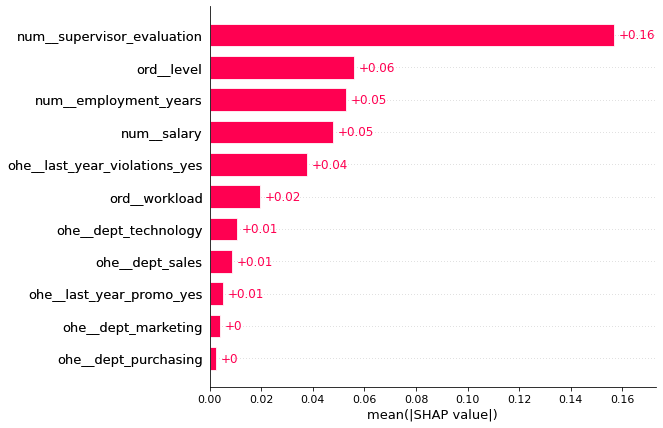

In [68]:
shap.plots.bar(shap_values, max_display=20) 

Из диаграммы видно, что наибольший вклад в предсказания модели вносит признак `supervisor_evaluation`, те оценка качества работы сотрудника руководителем. Вторым по значимости признаком является `level` - уровень должности, занимаемой сотрудником. Также влияют на предсказания модели `employment_years` длительность работы в компании и `salary` зарплата. Наименее значимыми оказались признаки - `dept` (отдел, в котором работал сотрудник) и `last_year_promo` (получал ли сотрудник повышение). 

## Задача 2: предсказание увольнения сотрудника из компании
Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

<a id='8'></a>
### Загрузка данных
Для этой задачи мы будем использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак будет отличаться: это quit — увольнение сотрудника из компании.

Загрузим тренировочную выборку:

In [69]:
df_quit_train = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')

In [70]:
main_info(df_quit_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
5,699916,sales,junior,low,1,no,yes,3,18000,yes
6,417070,technology,middle,medium,8,no,no,2,44400,no
7,165489,sales,middle,low,4,no,no,5,19200,no
8,996399,marketing,middle,low,7,no,no,4,25200,no
9,613206,technology,middle,medium,2,no,no,3,45600,yes




Общее число строк и столбцов в датафрейме:
(4000, 10)


Входные признаки тестовой выборки остались те же, что и в прошлой задаче.

In [71]:
features_test

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400
1996,109582,technology,middle,low,3,no,no,2,21600
1997,305653,technology,junior,low,1,no,no,3,14400
1998,160233,technology,middle,low,8,no,no,1,32400


Загрузим целевой признак тестовой выборки:

In [72]:
target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

In [73]:
main_info(target_quit)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
5,223063,no
6,810370,no
7,998900,no
8,578329,no
9,648850,no




Общее число строк и столбцов в датафрейме:
(2000, 2)


**Вывод:** все данные корректные и соответсвуют описанию, пропусков в данных  нет.

<a id='9'></a>
### Предобработка данных

Преобразуем столбец `id`  в индексы.

In [74]:
df_quit_train.set_index('id', inplace=True)

Проверим данные на наличие полных дубликатов.

In [75]:
df_quit_train.duplicated().sum()

1413

Удалим дубликаты в данных, так как они не нужны для обучения модели.

In [76]:
df_quit_train.drop_duplicates(inplace=True)
print ('Размер обучающей выборки после удаления дубликатов:', df_quit_train.shape)

Размер обучающей выборки после удаления дубликатов: (2587, 9)


Пропусков в данных обнаружено не было.

In [77]:
df_quit_train.isna().sum()

dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

**Выводы:** столбец с `id` пользователей был преобразован в индексы. После этого даннеы были проверены на наличие дубликатов. Всего было обнаружено 1413 повторяющихся строк. Было принято решение удалить их, так как повторяющиеся значения не принесут пользы при обучении модели. Пропусков в данных обнаружено не было.

<a id='10'></a>
### Исследовательский анализ
Проведем исследовательский анализ в разрезе целевого признака. В данном случае целеовй признак бинарный: `no` - сотрудник не уволился, `yes` - сотрудник уволился.

In [78]:
# отберем уволившихся сотрудников
df_no_quit = df_quit_train[df_quit_train['quit'] == 'no']
# отберем не уволившихся сотрудников
df_yes_quit = df_quit_train[df_quit_train['quit'] == 'yes']

Мы уже отбирали категориальные и количественные переменные. Построим для них графики и гистограммы.

In [79]:
# категориальные переменные
cat_col_names

['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

In [80]:
# количественные переменные
num_col_names

['employment_years', 'supervisor_evaluation', 'salary']

#### Количественные переменные

Исследуем значения в столбце `employment_years`.

Неуволившиеся сотрудники:

Статистические данные по столбцу "employment_years"


count    1932.000000
mean        4.908903
std         2.527730
min         1.000000
25%         3.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: employment_years, dtype: float64

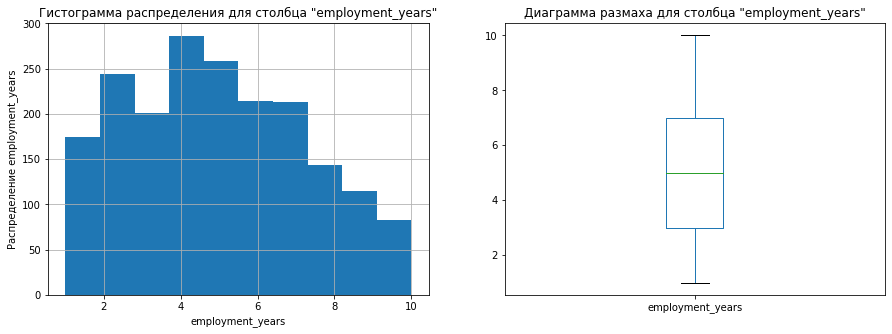

Уволившиеся сотрудники:

Статистические данные по столбцу "employment_years"


count    655.000000
mean       2.161832
std        1.497626
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       10.000000
Name: employment_years, dtype: float64

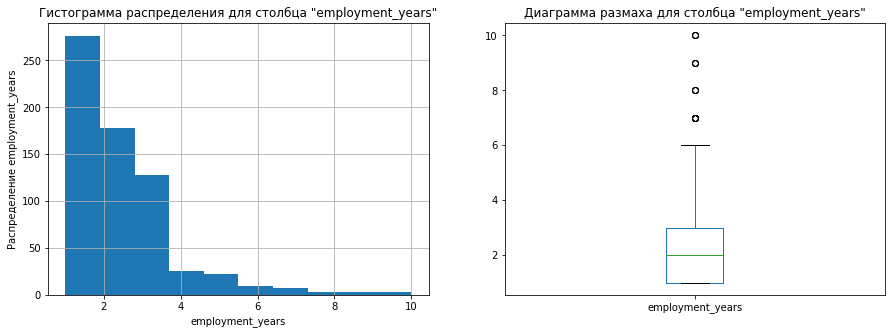

In [81]:
print(f'Неуволившиеся сотрудники:\n')
hist_boxplot(df_no_quit['employment_years'], 'employment_years')
print(f'Уволившиеся сотрудники:\n')
hist_boxplot(df_yes_quit['employment_years'], 'employment_years')

Среди неуволившися сотрудников средний опыт работы составляет около пяти лет, а среди тех, кто уволился - около двух. 75% уволившихся сотрудников проработали менее трех лет. Те в основном уволняются сотрудники, не преодолевшие трехлетний порог. Однако есть некоторое число выбросов: сотрудники, которые уволяются отработав 8 и более лет в компании.

Исследуем значения в столбце `supervisor_evaluation`.

Неуволившиеся сотрудники:

Статистические данные по столбцу "supervisor_evaluation"


count    1932.000000
mean        3.506729
std         1.055898
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

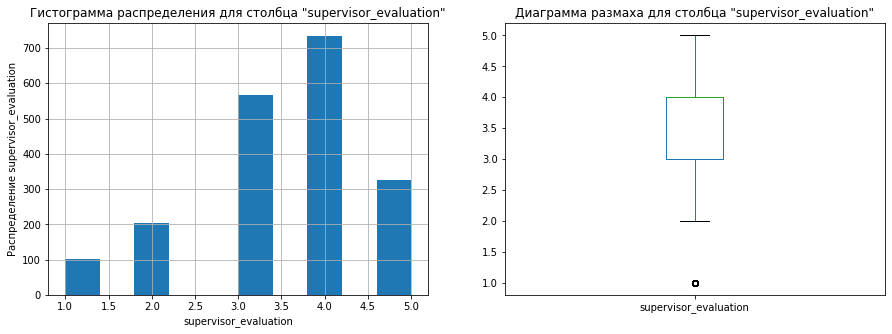

Уволившиеся сотрудники:

Статистические данные по столбцу "supervisor_evaluation"


count    655.000000
mean       2.958779
std        1.047705
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: supervisor_evaluation, dtype: float64

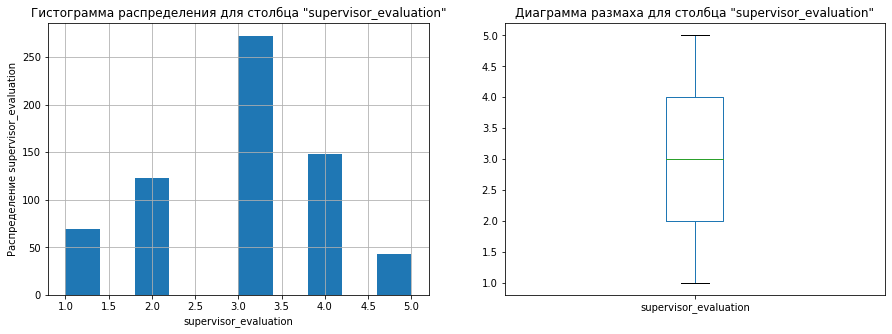

In [82]:
print(f'Неуволившиеся сотрудники:\n')
hist_boxplot(df_no_quit['supervisor_evaluation'], 'supervisor_evaluation')
print(f'Уволившиеся сотрудники:\n')
hist_boxplot(df_yes_quit['supervisor_evaluation'], 'supervisor_evaluation')

Среди неуволившихся сотрудников самая распространенная оценка - это 4. Среди уволившихся сотрудников наиболее частая оценка, полученная от руководителей - 3. Также доля пяторок больше среди сотрудников первой группы, чем среди второй.

Исследуем значения в столбце `salary`.

Неуволившиеся сотрудники:

Статистические данные по столбцу "salary"


count     1932.000000
mean     40952.173913
std      16085.739667
min      12000.000000
25%      27600.000000
50%      39000.000000
75%      51600.000000
max      96000.000000
Name: salary, dtype: float64

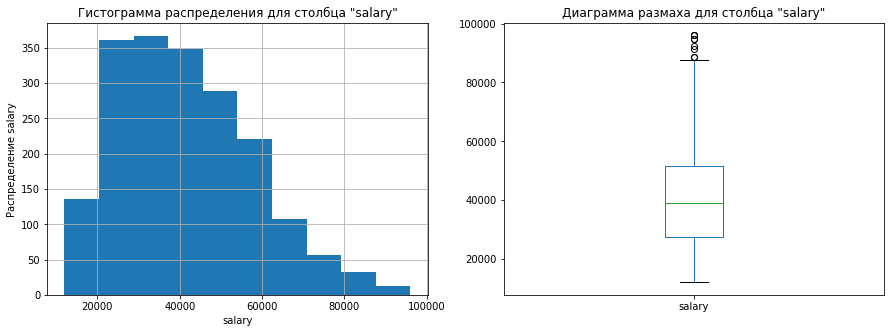

Уволившиеся сотрудники:

Статистические данные по столбцу "salary"


count      655.000000
mean     25767.938931
std      10484.828614
min      12000.000000
25%      18000.000000
50%      24000.000000
75%      30600.000000
max      79200.000000
Name: salary, dtype: float64

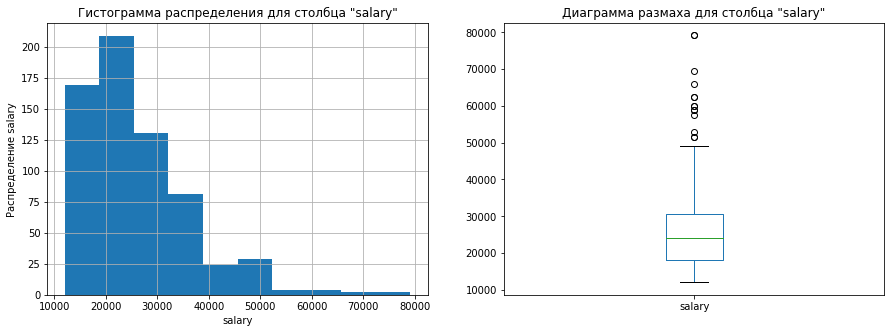

In [83]:
print(f'Неуволившиеся сотрудники:\n')
hist_boxplot(df_no_quit['salary'], 'salary')
print(f'Уволившиеся сотрудники:\n')
hist_boxplot(df_yes_quit['salary'], 'salary')

В среднем заработная плата уволившихся сотрудников была ниже, чем у неуволившихся. Медианная зарплата неуволившихся сотрудников составляет около 40 000 рублей, тогда как уволившегося - около 25 000. Разрыв между зарплатами в этих двух группах достаточно большой, однако можно наблюдать тенденцию к уволнению и среди сотрудников с высокими заработными платами. Так на диаграмме разброса для второй группы есть множество выбросов: сотрудники, чья зарплата составляет более 50 000 рублей.

#### Категориальные переменные

Пострим столбчатые диаграммы для признака `dept` и исследуем его в разрезе целевого признака.

Неуволившиеся сотрудники:

Столбчатая диаграмма для столбца "dept"
AxesSubplot(0.125,0.125;0.775x0.755)


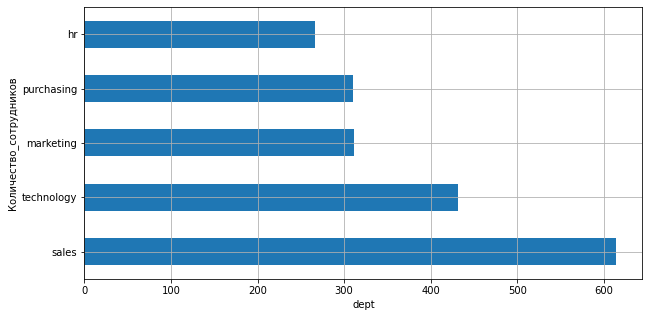

Уволившиеся сотрудники:

Столбчатая диаграмма для столбца "dept"
AxesSubplot(0.125,0.125;0.775x0.755)


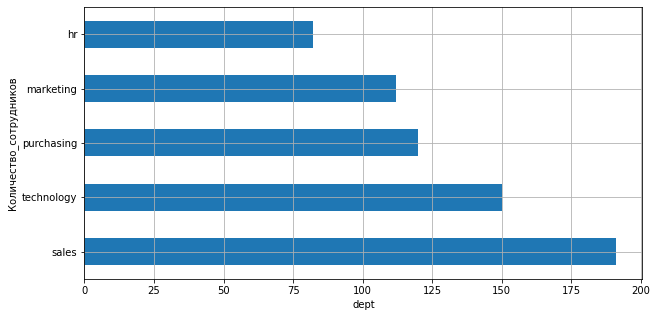

In [84]:
print(f'Неуволившиеся сотрудники:\n')
diag_bar(df_no_quit['dept'], 'dept')
print(f'Уволившиеся сотрудники:\n')
diag_bar(df_yes_quit['dept'], 'dept')

Больше всего уволившихся сотрудников в отделе `sales` и в отделе `technology`, меньше всего в отделе `hr`. Среди неуволившихся сотрудников ситуация такая же. В целом, соотношение уволившихся сотрудников относительно неуволившихся сотрудников во всех отделов примерно одинаковое.

Построим столбчатые диаграммы для признака `level`.

Неуволившиеся сотрудники:

Столбчатая диаграмма для столбца "level"
AxesSubplot(0.125,0.125;0.775x0.755)


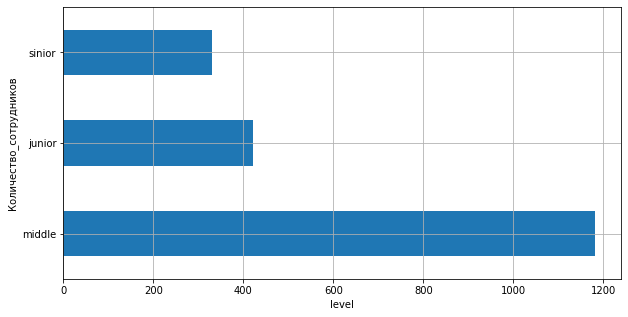

Уволившиеся сотрудники:

Столбчатая диаграмма для столбца "level"
AxesSubplot(0.125,0.125;0.775x0.755)


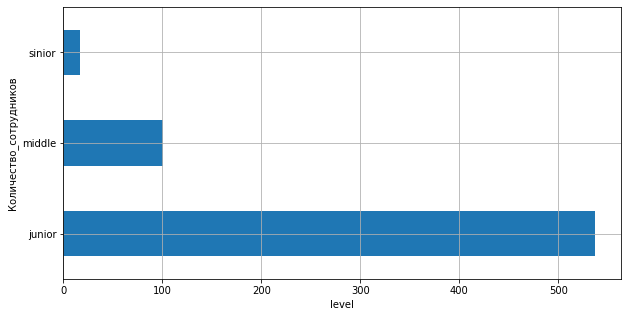

In [85]:
print(f'Неуволившиеся сотрудники:\n')
diag_bar(df_no_quit['level'], 'level')
print(f'Уволившиеся сотрудники:\n')
diag_bar(df_yes_quit['level'], 'level')

Подавляющее большинство уволившихся сотрудников имеют уровень `junior`. Среди продолживших работу в компании преобладают сотрудники уровня `middle`.

Построим диаграмму для признака `workload`.

Неуволившиеся сотрудники:

Столбчатая диаграмма для столбца "workload"
AxesSubplot(0.125,0.125;0.775x0.755)


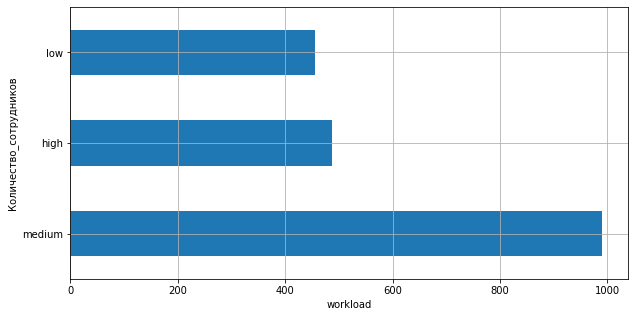

Уволившиеся сотрудники:

Столбчатая диаграмма для столбца "workload"
AxesSubplot(0.125,0.125;0.775x0.755)


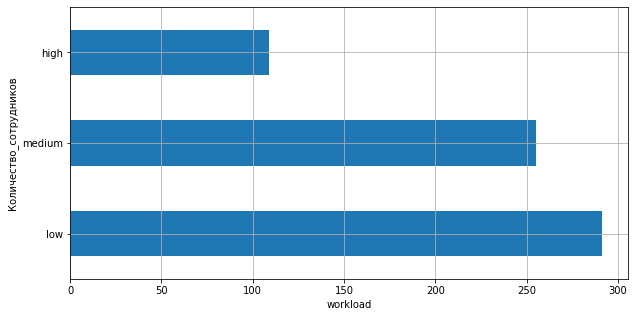

In [86]:
print(f'Неуволившиеся сотрудники:\n')
diag_bar(df_no_quit['workload'], 'workload')
print(f'Уволившиеся сотрудники:\n')
diag_bar(df_yes_quit['workload'], 'workload')

Большиинство уволившихся сотрудников имели низкий или средний уровень загруженности. Среди тех сотрудников, что остлись в компании, большинство имеет средний или высокий уровнь занятости.

Исследуем столбец `last_year_promo`, который содержит информацию о том, получал ли сотрудник повышения за прошедший год или нет.

Неуволившиеся сотрудники:

Столбчатая диаграмма для столбца "last_year_promo"
AxesSubplot(0.125,0.125;0.775x0.755)


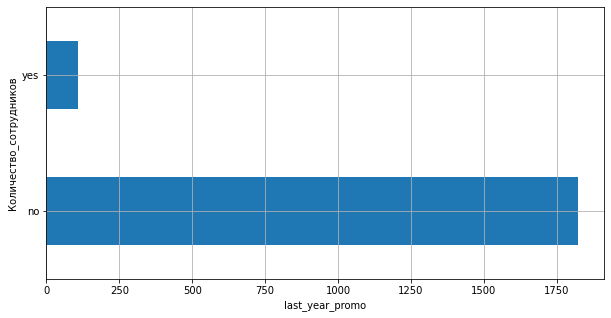

Уволившиеся сотрудники:

Столбчатая диаграмма для столбца "last_year_promo"
AxesSubplot(0.125,0.125;0.775x0.755)


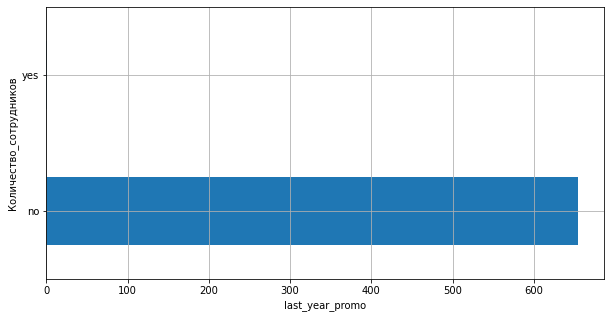

In [87]:
print(f'Неуволившиеся сотрудники:\n')
diag_bar(df_no_quit['last_year_promo'], 'last_year_promo')
print(f'Уволившиеся сотрудники:\n')
diag_bar(df_yes_quit['last_year_promo'], 'last_year_promo')

Среди уволившихся сотрудников никто не получал повышения, однако и среди первой группы сотрудников - повышение получила лишь малая часть сотрудников. Можно заметить, что наличие или отсуствие повышение, в данном случае, мало влияет на то, останется сотрудник в компании или нет.

Исследуем столбец `last_year_violations`, который содержит информацию о том, нарушал ли сотрудник трудовой договор.

Неуволившиеся сотрудники:

Столбчатая диаграмма для столбца "last_year_violations"
AxesSubplot(0.125,0.125;0.775x0.755)


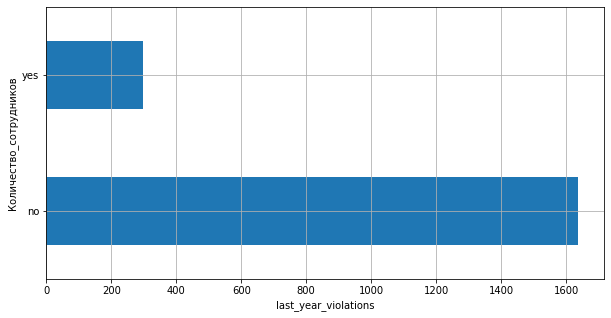

Уволившиеся сотрудники:

Столбчатая диаграмма для столбца "last_year_violations"
AxesSubplot(0.125,0.125;0.775x0.755)


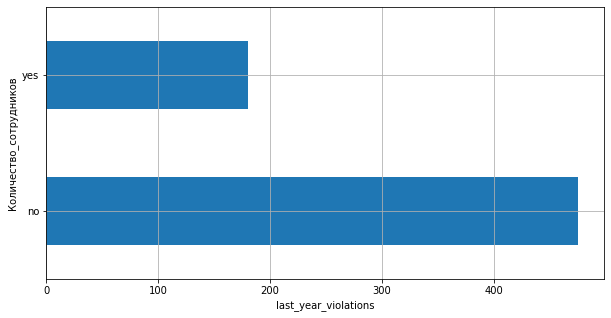

In [88]:
print(f'Неуволившиеся сотрудники:\n')
diag_bar(df_no_quit['last_year_violations'], 'last_year_violations')
print(f'Уволившиеся сотрудники:\n')
diag_bar(df_yes_quit['last_year_violations'], 'last_year_violations')

Среди уволившихся сотрудников доля тех, кто нарушал трудовой договор, выше, чем среди тех, кто остался работать в компании.

 #### Портрет "уволившегося сотрудника"
На основе проведенного анализа можно сделать некоторые выводы о том, какими чертами обладают сотрудники, которые уволняются чаще всего. Портрет "среднестатистичекого уволившегося сотрудника" может выглядеть так:
- средняя продолжительность работы в компании около двух лет;
- должность `junior`;
- медианная зарплата около 25 000 рублей;
- уровень загруженности работой низкий `low`;
- наиболее частая оценка работы от руководства компании - 3 балла.

Таким образом, наиболее часто уволняются новые сотрудники, которые отработалии в компании около двух лет, на низкой должности и с невысокой зарплатой.

Рассчитаем долю уволившихся сотрудников, относительно общего числа сотрудников.

In [89]:
df_yes_quit['quit'].count()/df_quit_train['quit'].count()

0.2531890220332431

Примерно четверть сотрудников ушла из компании за последний год. Посмотрим, из каких отделов сотрудники уволняются чаще всего.

In [90]:
df_prop_dept = (df_quit_train
                .reset_index('id')
                .pivot_table(index='dept', columns = 'quit', values='id', aggfunc='count'))
df_prop_dept['proportion_quit'] = df_prop_dept['yes']/(df_prop_dept['no']+df_prop_dept['yes'])
df_prop_dept.sort_values(by='proportion_quit', ascending=False)

quit,no,yes,proportion_quit
dept,,,
purchasing,310,120,0.279070
marketing,311,112,0.264775
technology,431,150,0.258176
sales,614,191,0.237267
hr,266,82,0.235632


Больше всего сотрудников ушло из отдела снабжения `purchasing`, на втором месте отдел маркетинга `marketing`. В целом доля ушедших сотрудников во всех отделов примерно одинаковая.

По каждому отделу сравним медианное значение зарплаты ушедших сотрудников с теми, кто остался.

In [91]:
df_prop_salary = (df_quit_train
                .reset_index('id')
                .pivot_table(index='dept', columns = 'quit', values='salary', aggfunc='median'))
df_prop_salary['proportion_salary'] = df_prop_salary['no']/df_prop_salary['yes']
df_prop_salary.sort_values(by='proportion_salary', ascending=False)

quit,no,yes,proportion_salary
dept,,,
marketing,40800,24000,1.700000
sales,38400,22800,1.684211
purchasing,37200,22800,1.631579
technology,44400,27600,1.608696
hr,36000,22800,1.578947


Наибольший разрыв между зарпалатами наблюдается в отделах маркетинга и продаж. Там зарплата неуволившихся сотрудников приблизительно в 1.7 раза выше, чем уволившихся. Наименьший разрыв в отделе `hr`: зарплаты неуволившихся сотрудников в 1.58 раза выше, чем уволившихся. В целом, во всех отделах оставшиеся сотрудники получали больше, чем те, кто ушли.

Таким образом, в дополнение к вышеуказанному портрету можно добавать следующие замечания: уволившийся сотрудник практически с равной вероятностью может оказаться как из отдела снабжения `purchasing`, так и из отдела маркетинга `marketing` или технологий `technology`. Заработная плата ушедших сотрудников примерно в 1.6 раз меньше, чем оставшихся: наибольший разрыв между зарпалатами в отделе `marketing`, наименьший - в `hr`.

#### Связь между `job_satisfaction_rate` и `quit`

Проверим, как уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Для этого визуализируем и сравним распределения признака `job_satisfaction_rate` для ушедших и оставшихся сотрудников. Для этого для начала объеденим тестовую выборку и целевой признак `target_quit` в один датафрем `quit_full`.

In [92]:
quit_full = features_test.merge(target_quit, on='id')
print('Размерность первого датафрейма', quit_full.shape)
quit_full.head()

Размерность первого датафрейма (2000, 10)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,no
1,686555,hr,junior,medium,1,no,no,4,30000,no
2,467458,sales,middle,low,5,no,no,4,19200,no
3,418655,sales,middle,low,6,no,no,4,19200,no
4,789145,hr,middle,medium,5,no,no,5,40800,no


In [93]:
print('Размерность второго датафрейма', test_full.shape)
test_full.head()

Размерность второго датафрейма (2000, 10)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


Затем объеденим два датафрейма `quit_full` и `test_full`, содержащих тестовые выборки и целевой признак из первой и второй задачи.

In [94]:
df_general = quit_full.join(test_full['job_satisfaction_rate'])
print('Размерность объединенного датафрейма', df_general.shape)
df_general.head()

Размерность объединенного датафрейма (2000, 11)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,no,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,no,0.72
2,467458,sales,middle,low,5,no,no,4,19200,no,0.64
3,418655,sales,middle,low,6,no,no,4,19200,no,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,no,0.75


Для построения матрицы корреляции отберем только нужные параметры.

In [95]:
df_corr = pd.DataFrame()
df_corr = df_general[['quit', 'job_satisfaction_rate']]

Построим матрицу корреляции с помощью метода `phik`.

interval columns not set, guessing: ['job_satisfaction_rate']


<AxesSubplot:>

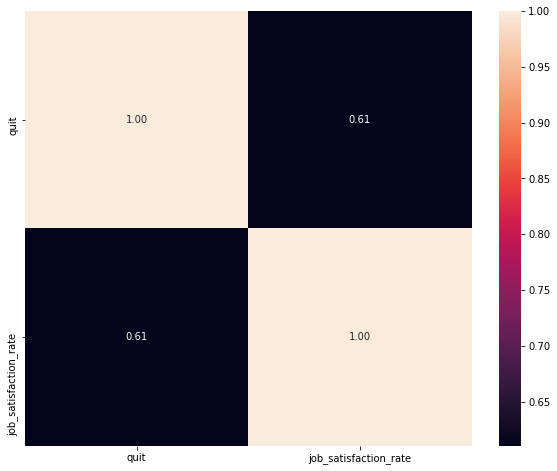

In [96]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
sns.heatmap(df_corr.phik_matrix(), annot=True, fmt='.2f')

**Вывод:** корреляция между признаками `job_satisfaction_rate` и `quit` составляет 0.61. Можно утверждать, что некоторая линейная взаимосвязь между этими двумя признаками присутствует, поэтому можно использовать признак `job_satisfaction_rate` как входной признак для дальнейших предсказаний модели.

Визуализируем и сравним распределения признака `job_satisfaction_rate` для ушедших и оставшихся работников.

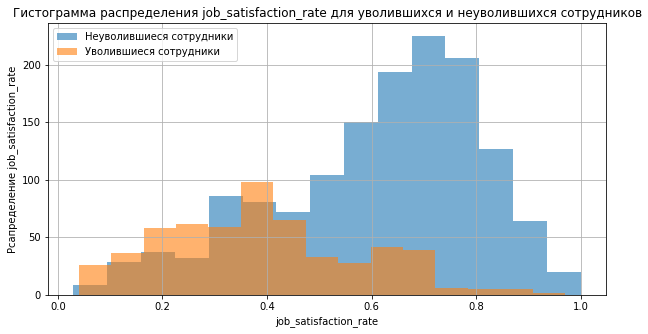

In [97]:
# отберем неуволившихся работников и построим для них гистограмму
(df_general[df_general['quit']=='no']['job_satisfaction_rate']
.plot(kind='hist', bins=15, grid=True, figsize=(10,5), alpha=0.6,
     label='Неуволившиеся сотрудники')
)
# отберем уволившихся сотрудников и построим для них гистограмму
(df_general[df_general['quit']=='yes']['job_satisfaction_rate']
.plot(kind='hist', bins=15, grid=True, figsize=(10,5), alpha=0.6,
     label='Уволившиеся сотрудники')
)
plt.ylabel('Рсапределение job_satisfaction_rate')
plt.xlabel('job_satisfaction_rate')
plt.title('Гистограмма распределения job_satisfaction_rate для уволившихся и неуволившихся сотрудников')
plt.legend()
plt.show();

Распределение для уволившихся сотрудников смешено влево относительно распределения для неуволившихся. Наиболее частое значение рейтинга удовлетворенности среди уволившихся сотрудников составляло около 0.4. тогда как среди неуволившихся - около 0.7.

Построим диаграммы размаха значений, для того чтобы сравнить показатели `job_satisfaction_rate` для двух групп.

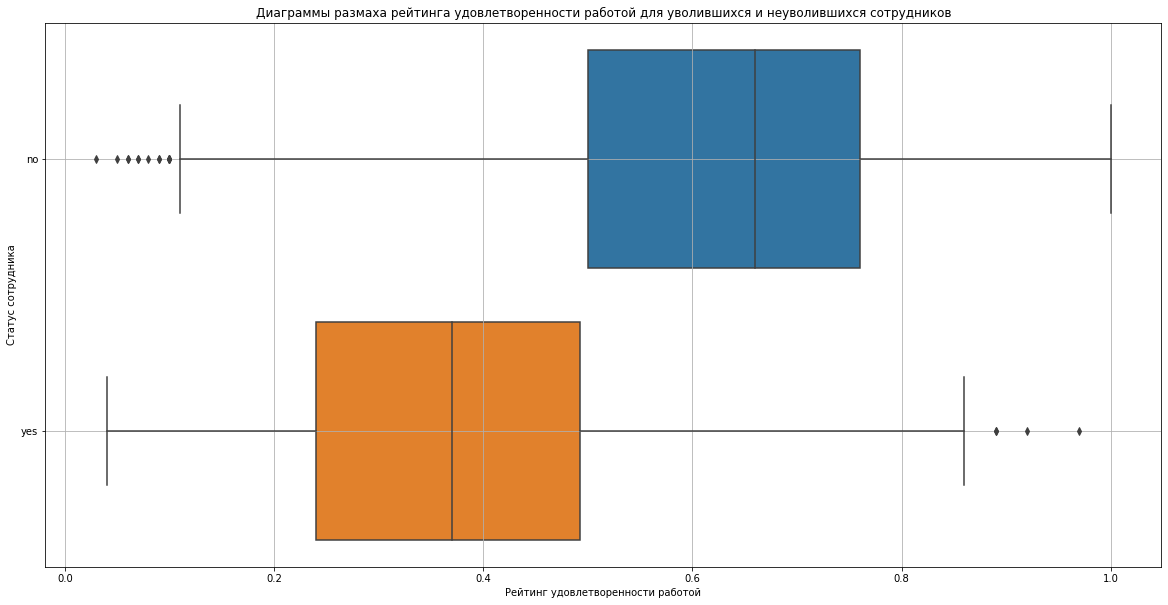

In [98]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df_general, x='job_satisfaction_rate', y='quit', orient='h')
plt.title("Диаграммы размаха рейтинга удовлетворенности работой для уволившихся и неуволившихся сотрудников")
plt.grid(True)
plt.xlabel('Рейтинг удовлетворенности работой')
plt.ylabel('Статус сотрудника');

Медианные значения рейтингов для двух групп сотрудников значительно различаются: значение для неуволившихся сотрудников - около 0.65, а для уволившихся менее 0.4. 

75% неуволившихся сотрудников имеют рейтинг менее 0.75, тогда как 75% уволившихся сотрудников - менее 0.5. Среди обехих групп есть небольшое число выбросов: уволившиеся сотрудники с высоким рейтингом удовлетворенности и оставшиеся сотрудники, у которых при этом низкие показатели удовлетворенности работой.

Проверим наше предположение о том, что уровень удовлетворенности неуволившихся работников выше, чем у уволившихся работников. Сформулируем две гипотезы.

**Нулевая гипотеза:** "среднее значение `job_satisfaction_rate` для неуволившегося сотрудника равно среднему значению `job_satisfaction_rate` для уволившегося сотрудника"<br>

**Альтернативная гипотеза:** "среднее значение `job_satisfaction_rate` для неуволившегося сотрудника выше среднего значения `job_satisfaction_rate` для уволившего сотрудника"<br>

Для проверки гипотез используем t-тест.

In [99]:
# выборка уровня удовлетворенности неуволившихся сотрудников
rate_quit_no = df_general[df_general['quit']=='no']['job_satisfaction_rate']
# выборка уровня удовлетворенности уволившихся сотрудников
rate_quit_yes = df_general[df_general['quit']=='yes']['job_satisfaction_rate']

In [100]:
# выбранный уровень статистической значимости
alpha = 0.05

results = st.ttest_ind(rate_quit_no, rate_quit_yes, alternative='greater')

print('p-значение: ', results.pvalue)

# проверяем, отвеграем нулевую гипотезу или нет
if results.pvalue < alpha:
    print ('Отвергаем нулевую гипотезу')
else: 
    print ('Нет оснований отвергнуть нулевую гипотезу')

p-значение:  6.155610332585965e-105
Отвергаем нулевую гипотезу


**Вывод:** Значение p-value меньше выбранного уровня статистической значимости, значит отвергаем нулевую гипотезу в пользу альтернативной: "среднее значение `job_satisfaction_rate` для неуволившегося сотрудника выше среднего значения `job_satisfaction_rate` для уволившего сотрудника"

<a id='11'></a>
### Добавление нового входного признака
Добавим `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [101]:
# предсказания лучшей модели из первой задачи
pred_job_satisfaction_rate.head()

,id,pred_job_satisfaction_rate
0,485046,0.860000
1,686555,0.680000
2,467458,0.690000
3,418655,0.713333
4,789145,0.710952


In [102]:
# входные признаки
features_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Объединим пресдказания `pred_job_satisfaction_rate` и входные признаки `features_test` по столбцу `id`.

In [103]:
features_test_2 = features_test.merge(pred_job_satisfaction_rate, on='id')
features_test_2.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,pred_job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.860000
1,686555,hr,junior,medium,1,no,no,4,30000,0.680000
2,467458,sales,middle,low,5,no,no,4,19200,0.690000
3,418655,sales,middle,low,6,no,no,4,19200,0.713333
4,789145,hr,middle,medium,5,no,no,5,40800,0.710952


<a id='12'></a>
### Подготовка данных
#### Тренировочная выборка
После предобработки и удаления дубликатов у нас получился следующий дататфрейм с тренировочной выборкой:

In [104]:
print ('Размерность тренировочной выборки:', df_quit_train.shape)
df_quit_train.head()

Размерность тренировочной выборки: (2587, 9)


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


Удалим целевой признак и оставим только входные признаки.

In [105]:
X_train_quit = df_quit_train.drop('quit', axis=1)

Добавим к тренировочной выбрке предсказания параметра `job_satisfaction_rate`, которые мы получим на основе лучшей модели из первой части проекта.

In [106]:
X_train_quit['pred_job_satisfaction_rate'] = best_model.predict(X_train_quit)
# выделим целевой признак
y_train_quit = df_quit_train['quit']

In [107]:
print ('Размерность тренировочной выборки:', X_train_quit.shape)
X_train_quit.head()

Размерность тренировочной выборки: (2587, 9)


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,pred_job_satisfaction_rate
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0.620000
814010,sales,junior,medium,2,no,no,4,27600,0.853529
155091,purchasing,middle,medium,5,no,no,1,37200,0.332500
257132,sales,junior,medium,2,no,yes,3,24000,0.358750
910140,marketing,junior,medium,2,no,no,5,25200,0.791667


In [108]:
# целевая переменная тренировочной выборки
y_train_quit

id
723290     no
814010     no
155091     no
257132    yes
910140     no
         ... 
778735    yes
106936     no
775320    yes
536432    yes
692133     no
Name: quit, Length: 2587, dtype: object

Получившиеся датафреймы `X_train_quit` и `y_train_quit` будем использовать для обучения модели.
#### Тестовая выборка
После добавления нового входного признака `pred_job_satisfaction_rate` мы получили датафрейм `features_test_2`. Обеъеденим этот датафрейм с целевой переменной `target_quit` по `id`.

In [109]:
features_test_2 = features_test_2.merge(target_quit, on='id')
print('Размерность получившегося датафрейма:', features_test_2.shape)
features_test_2.head()

Размерность получившегося датафрейма: (2000, 11)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,pred_job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.860000,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.680000,no
2,467458,sales,middle,low,5,no,no,4,19200,0.690000,no
3,418655,sales,middle,low,6,no,no,4,19200,0.713333,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.710952,no


Удалим колонку с целевым признаком и преобразуем колнку `id`  в индексы. Таким образом, получим финальный датафрейм с тестовой выборкой.

In [110]:
X_test_quit = features_test_2.drop('quit', axis=1)
X_test_quit.set_index('id', inplace=True)

In [111]:
print ('Размерность тестовой выборки:', X_test_quit.shape)
X_test_quit.head()

Размерность тестовой выборки: (2000, 9)


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,pred_job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.860000
686555,hr,junior,medium,1,no,no,4,30000,0.680000
467458,sales,middle,low,5,no,no,4,19200,0.690000
418655,sales,middle,low,6,no,no,4,19200,0.713333
789145,hr,middle,medium,5,no,no,5,40800,0.710952


In [112]:
# целевая переменная
y_test_quit = features_test_2['quit']
y_test_quit

0        no
1        no
2        no
3        no
4        no
       ... 
1995    yes
1996    yes
1997    yes
1998     no
1999     no
Name: quit, Length: 2000, dtype: object

#### Кодирование целевого признака
С помощью `LabelEncoder()` закодируем целевой признак порядковыми числами. Обучим кодировщик на тестовой выборке и закодируем с помощью него трнировочные и тестовые данные.

In [113]:
label_encoder = LabelEncoder()
# обучим кодировщик на тренировчоной выборке
y_train_quit = label_encoder.fit_transform(y_train_quit)
# закодируем данные в тестовой выборке
y_test_quit = label_encoder.transform(y_test_quit)

In [114]:
# значение целевого признака после кодирования 
y_test_quit

array([0, 0, 0, ..., 1, 0, 0])

Таким образом, значения `no` (сотрудник не уволится) были закодированы как 0, значения `yes` (сотрудник уволится) - 1.

#### OHE-кодирование
Создадим пайплайн `ohe_pipe_task_2`, содержащий шаги по заполнению пропусков и пустых строк наиболее частым значением с помощью `SimpleImputer` и кодированию данных.

In [115]:
ohe_pipe_task_2 = Pipeline(
    [
        (
            'simple_imputer_ohe_1',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        
        (
            'simple_imputer_ohe_2',
            SimpleImputer(missing_values=' ', strategy='most_frequent')
        ),
        (
            'ohe',
             OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
)

Отберем категориальные признаки, к которым будем применять OHE-кодирование.

In [116]:
ohe_columns_task_2 = X_train_quit.select_dtypes(exclude='number').columns.tolist()
# исключим признаки, к которым применим Ordinal-кодирование
ohe_columns_task_2.remove('level')
ohe_columns_task_2.remove('workload')
# выведем список признаков
ohe_columns_task_2

['dept', 'last_year_promo', 'last_year_violations']

#### Ordinal-кодирование
Создадим пайплайн `ord_pipe_task_2`, который содержит шаги по заполненю пропусков в данных наиболее частым занчением с помощью `SimpleImputer` и кодированию признаков с учетом порядка категоризации.

In [117]:
ord_pipe_task_2 = Pipeline(
    [
        
        (
        'simple_imputer_befor_ord',
        SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan)
        ),
        
        (
            'simple_imputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
        
    ]
)

Список признаков, к которым применим Ordinal-кодирование.

In [118]:
ord_columns_task_2 = ['level', 'workload']

Список количественных признаков, к которым применим масштабирование.

In [119]:
num_columns_task_2 = X_train_quit.select_dtypes(include='number').columns.tolist()
num_columns_task_2

['employment_years',
 'supervisor_evaluation',
 'salary',
 'pred_job_satisfaction_rate']

#### Финальный пайплайн
Создадим пайплайн предобработки данных `data_preprocessing_task_2`, где с помощью `ColumnTransformer` объединим пайплайны для масштабирования и кодирования данных. 

In [120]:
data_preprocessing_task_2 = ColumnTransformer(
    [
        ('ohe', ohe_pipe_task_2, ohe_columns_task_2),
        ('ord', ord_pipe_task_2, ord_columns_task_2),
        ('num', StandardScaler(), num_columns_task_2)
    ],
    remainder='passthrough'
)

Создадим финальный пайплайн.

In [121]:
pipe_final_classifier = Pipeline(
    [
        ('preprocessor', data_preprocessing_task_2),
        ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

Обучим три модели: дерева решений `DecisionTreeСlassifier`, логистической регрессии `LogisticRegression` и метод ближайших соседей `KNeighborsClassifier`. Создадим словарь гиперпараметров, где для каждой модели укажем гиперпараметры. 

In [122]:
parameters_grid_class = [
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': range(2,20),
        'model__max_features': range(5,10),
        'model__min_samples_split': range(2,10),
        'model__min_samples_leaf': range(2,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE)],
        'model__solver': ['liblinear', 'saga'],
        'model__penalty': ['l1', 'l2'],
        'model__C': range(1,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': range(1,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]

<a id='13'></a>
### Обучение модели

Найдем лучшую модель на тренировчоных данных с помощью `RandomizedSearchCV`. В качестве метрики для оценки качества модели передадим свою метрику `roc_auc`. Критерий успеха: ROC-AUC ≥0.91 на тестовой выборке.

In [123]:
random_search_2 = RandomizedSearchCV(
    pipe_final_classifier,
    parameters_grid_class,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    n_iter=20,
    random_state=RANDOM_STATE
)

In [124]:
random_search_2.fit(X_train_quit, y_train_quit)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simple_imputer_ohe_1',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('simple_imputer_ohe_2',
                                                                                                SimpleImputer(missing_values=' ',
                                                                                                              strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'...
                                                               MinMaxScaler()]},
                                        {'model': [LogisticRegression(random_state=42)],
                                         'model__C': range(1, 10),
                                         'model__penalty': ['l1', 'l2'],
                                         'model__solver': ['liblinear', 'saga'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'model': [KNeighborsClassifier()],
                                         'model__n_neighbors': range(1, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42, scoring='roc_auc')

Найдем лучшую модель и ее параметры.

In [125]:
best_model_classifier = random_search_2.best_estimator_

In [126]:
print('Параметры лучшей модели:')
random_search_2.best_params_

Параметры лучшей модели:


{'preprocessor__num': MinMaxScaler(),
 'model__min_samples_split': 2,
 'model__min_samples_leaf': 2,
 'model__max_features': 9,
 'model__max_depth': 5,
 'model': DecisionTreeClassifier(max_depth=5, max_features=9, min_samples_leaf=2,
                        random_state=42)}

In [127]:
print('Метрика лучшей модели на тренировочной выборке:', random_search_2.best_score_)

Метрика лучшей модели на тренировочной выборке: 0.9003290247933446


Рассчитаем метрику `roc_auc` на тестовой выборке. Для этого сначала подготовим тестовые данные с помощью шага `preprocessor` лучшей модели `best_model_classifier`. 

In [128]:
X_train_quit_prep = pipe_final_classifier.named_steps['preprocessor'].fit_transform(X_train_quit)
X_test_quit_prep = pipe_final_classifier.named_steps['preprocessor'].transform(X_test_quit)

Получим предсказание модели. В переменную `y_predict_quit` сохраним вероятность предсказания класса 1. Рассчитаем метрику `roc_auc_score`.

In [130]:
y_predict_quit = best_model_classifier.predict_proba(X_test_quit)[:,1]
print ('Метрика лучшей модели на тестовых данных:', roc_auc_score(y_test_quit, y_predict_quit))

Метрика лучшей модели на тестовых данных: 0.9170234990813725


Выведем список лучших моделей, полученных в процессе подбора гиперпараметров `RandomizedSearchCV`. Отберем только необходимые столбцы и отсортируем модели в порядке убывания.

In [131]:
result_models_2 = pd.DataFrame(random_search_2.cv_results_)
# отсортируем их по убыванию метрики и выведем топ-10 лучших моделей.
(result_models_2[['rank_test_score', 'param_model', 'mean_test_score','params']]
.sort_values('rank_test_score')
.head(10))

,rank_test_score,param_model,mean_test_score,params
17,1,"DecisionTreeClassifier(max_depth=5, max_featur...",0.900329,"{'preprocessor__num': MinMaxScaler(), 'model__..."
13,2,"DecisionTreeClassifier(max_depth=5, max_featur...",0.898717,"{'preprocessor__num': MinMaxScaler(), 'model__..."
11,3,"DecisionTreeClassifier(max_depth=5, max_featur...",0.896883,"{'preprocessor__num': MinMaxScaler(), 'model__..."
0,4,"DecisionTreeClassifier(max_depth=5, max_featur...",0.895920,"{'preprocessor__num': StandardScaler(), 'model..."
5,5,"DecisionTreeClassifier(max_depth=5, max_featur...",0.893404,"{'preprocessor__num': StandardScaler(), 'model..."
8,6,"DecisionTreeClassifier(max_depth=5, max_featur...",0.892929,"{'preprocessor__num': StandardScaler(), 'model..."
6,7,"DecisionTreeClassifier(max_depth=5, max_featur...",0.892656,"{'preprocessor__num': MinMaxScaler(), 'model__..."
10,8,"DecisionTreeClassifier(max_depth=5, max_featur...",0.892046,"{'preprocessor__num': MinMaxScaler(), 'model__..."
3,9,"DecisionTreeClassifier(max_depth=5, max_featur...",0.890958,"{'preprocessor__num': MinMaxScaler(), 'model__..."
15,10,"DecisionTreeClassifier(max_depth=5, max_featur...",0.890027,"{'preprocessor__num': MinMaxScaler(), 'model__..."


**Выводы:** 
Лучшей модель является модель `DecisionTreeClassifier()` со следубщими параметрами:
- `model__min_samples_split`: 2,
- `model__min_samples_leaf`: 2,
- `model__max_features`: 9,
- `model__max_depth`: 5.

Метод масштабирования: `MinMaxScaler()`.
Метрика ROC_AUC на теренировочных данных равняется 0.9. Метрика ROC_AUC на тестовых данных равняется 0.917. Критерием успеха считается, если метрика превышет порог в 0.91.

Так как в данных много категориальных переменных, то в топ-10 лучших моделей входят модели `DecisionTreeClassifier()`, так модель дерева решений лучше работает с категориальными признаками.

<a id='14'></a>
### Выводы

In [132]:
# предадим TreeExplainer лучшую модель и тренировочную выборку
explainer_2 = shap.TreeExplainer(best_model_classifier.named_steps['model'], X_train_quit_prep)
# список наименований признаков
feature_names_2 = best_model_classifier.named_steps['preprocessor'].get_feature_names_out()
feature_names_2

array(['ohe__dept_marketing', 'ohe__dept_purchasing', 'ohe__dept_sales',
       'ohe__dept_technology', 'ohe__last_year_promo_yes',
       'ohe__last_year_violations_yes', 'ord__level', 'ord__workload',
       'num__employment_years', 'num__supervisor_evaluation',
       'num__salary', 'num__pred_job_satisfaction_rate'], dtype=object)

In [133]:
# найдем shap-значения
shap_values_2 = explainer_2.shap_values(X_train_quit_prep)

Построим диаграмму важности признаков для всей модели в общем:

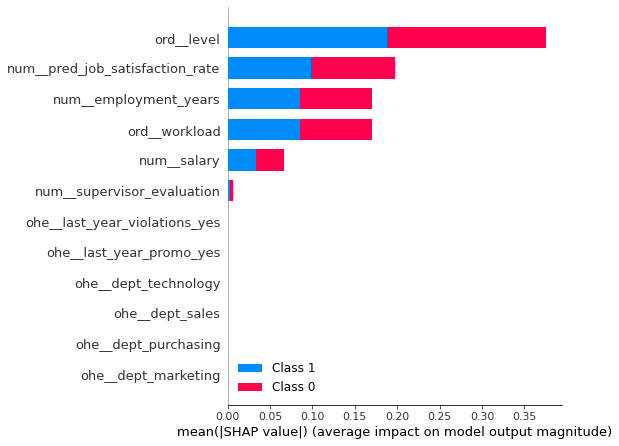

In [134]:
shap.summary_plot(shap_values_2, X_train_quit_prep, feature_names_2, max_display=20) 

Из диаграммы видно, что наибольший вклад в классификацию вносят  уровень занимаемой должности `level`, уровень удовлетворенности работой `job_satisfaction_rate`, длительность работы в компании `employment_years` и уровень занятости `workload`. Наименее влияют на предсказание модели: отдел, в котором работал сотрудник, получал он повышение или нет, а также факт нарушения трудового договора.

Построим диаграмму, которая показывает, какой вклад каждый признак вносит в классификацию каждого отдельного наблюдения.

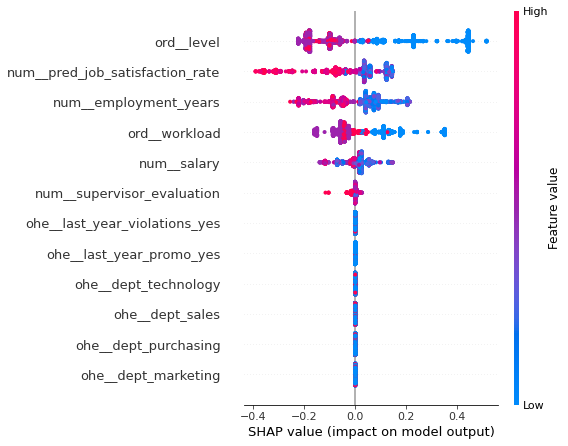

In [135]:
shap.summary_plot(shap_values_2[1], X_train_quit_prep, feature_names_2, max_display=20) 

Исходя из диаграммы следует, что чем больше значения признаков `level`, `job_satisfaction_rate`, `employment_years` и `workload`, тем больше вероятность отнесения объекта к классу 0 (те сотрудник не уволится). И, наоборот, чем ниже значения этих признаков, тем более модель склоняется к классу 1, те "сотрудник уволится". Как было отмечено ранее, мы установили, что наиболее часто уволняются сотрудники на должности `junior` с низким уровнем занятости `low`, которые отработали в компании до 2-х лет. 

<a id='15'></a>
## Общий вывод
Для работы были получены следующие данные:
- датасет с тренировочной выборкой (различные для двух задач)
- датасет с входными признаками (одинаковый для двух задач)
- датасетс целевым признаком (различные для двух задач: для первой задачи необходимо было предсказать непрерывный количественный признак `job_satisfaction_rate`, для второй - бинарный категориальный `quit`).

Структура входных признаков была следующая:
- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;

Целевые признаки:
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.
- `quit` — увольнение сотрудника из компании.

<font size=+1><b>Задача 1</b></font>

В результате предобработки из тренировочной выборки было удалено 245 полных дубликатов, те такие сотрудники, у которых полностью совпадают все признаки кроме `id`. В столбце `dept` и `level` были обнаружены пропуски и пустые строки, которые были обработаны в пайплайне на этапе подготовки данных.

В результате исследовательского анализа были выявлены следующие закономерности:
- Средний срок сработы в компании - около трех лет.
- В заработных платах сотрудников есть некоторое количество выбросов - зарплаты свыше 80 000 рублей (при медианной зарпалате в 31 200 рублей). Все сотрудники, получающие заработную плату свыше 80 000 рублей, являются сеньорами и имеют высокий уровень загруженность.
- Большинство "новичков", работающих менее 1 года имеют удовлетворенность работой менее 0.5.
- Среди сотрудников, чья удовлетворенность выше 0.5, подавляющее большинство  имеет оценку от руководства - 4, среди сотрудников во второй категории - 3.
- Большинство сотрудников работает в отделе продаж `sales`, второе место занимает отдел `technology`, наименее популярный отдел - `hr`.
- Сотрудников уровня `middle` и `junior` примерно поровну - свыше 1600, сотрудников уровня `sinior` гораздо меньше - менее 400.
- Среди сотрудников с низким уровнем удовлетворенности работой около трети получали выговор по трудовому договору за прошлый год, тогда как среди тех, кто удовлетворен своей работой более чем на 0.5 доля выговоров гораздо меньше.

Затем был создан пайплайн  для подготовки данных `data_preprocessing`, где с помощью `ColumnTransformer` были объеденины шаги по масштабированию и кодированию данных, а также было указано, к каким данным их следует применять: к категориальным признакам было применено `OHE-кодирование`, признаки `level` и `workload` были закодирован с помощью `Ordinal-кодирования`. Методы масштабирования количественных данных `StandardScaler()`, `MinMaxScaler()` перебирались как и гиперпараметры для каждой модели отдельно. Пропуски в данных были заполнены с помощью `SimpleImputer()` наиболее частым значением.

Итоговый пайплайн `pipe_final`включал в себя следующие шаги:
- подготовка данных — шаг `preprocessor`;
- инициализация модели — шаг `model`.

Был составлен словарь `parameters_grid`, где были указаны гиперпараметры и методы масштабирования для двух моделей: `DecisionTreeRegressor()`и `LinearRegression()`. Для автоматического подбора гиперпараметров был использован инструмент `RandomizedSearchCV`. Для оценки качества модели с была создана своя метрика `SMAPE_metric`.

В результате лучшей моделью является модель дерева решений `DecisionTreeRegressor` с параметрами:
- `model__min_samples_split`: 3,
- `model__min_samples_leaf`: 3,
- `model__max_features`: 8,
- `model__max_depth`: 13.

Метод масштабирования: `StandardScaler()`.

Метрика SMAPE на тестовых данных составила 16.3. В топ-10 моделей с лучшими метриками попали только модели дерева решений.

<font size=+1><b>Задача 2</b></font>

В результате предобработки из тренировочной выборки было удалено 1413 полных дубликатов, те такие сотрудники, у которых полностью совпадают все признаки кроме `id`.

После исследовательского анализа был составлен портрет среднестатистического "уволившегося сотрудника":
- средняя продолжительность работы в компании около двух лет;
- должность `junior`;
- медианная зарплата около 25 000 рублей;
- уровень загруженности работой низкий `low`;
- наиболее частая оценка работы от руководства компании - 3 балла.

Таким образом, наиболее часто уволняются новые сотрудники, которые отработалии в компании около двух лет, на низкой должности и с невысокой зарплатой.

Была выявлена корреляция между признаками `job_satisfaction_rate` и `quit`, которая составила 0.61. Поэтому предсказания признака `job_satisfaction_rate`, полученные с помощью лучшей модели из первой задачи, были добавлены к входным признакам второй задачи для дальнейших предсказаний модели.

Подготовка данных во второй задачи с помощью пайплайнов была выполнена по той же логике, что и в первом случае. Целевой признак `quit` был закодирован с помощью `LabelEncoder()`.

В результате лучшей модель является модель `DecisionTreeClassifier()` со следубщими параметрами:
- `model__min_samples_split`: 2,
- `model__min_samples_leaf`: 2,
- `model__max_features`: 9,
- `model__max_depth`: 5.

Метод масштабирования: `MinMaxScaler()`.

Метрика ROC_AUC на теренировочных данных равняется 0.9. Метрика ROC_AUC на тестовых данных равняется 0.919. Критерием успеха считается, если метрика превышет порог в 0.91.

По итогам проведенного исследования, можно сделать вывод, что компании нужно уделить больше внимания сотрудникам на должности `junior`, которые отработали в компании менее двух лет. У таких сотрудников как правило низкий уровень загруженности и низкая медианная зарплата. Сотрудники из этой категории склонны увольняться чаще всего, отработав в компании меньше трех лет. Также уровень удовлетворенности работой в компании достаточно сильно влияет на то, уволится сотрудник или нет. Чем он ниже, тем больше вероятность того, что сотрудник покинет компанию.